In [1]:
import os
import re
from collections import Counter
from pathlib import Path

import pandas as pd
import scanpy as sc
import tifffile
from PIL import Image

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from violet.utils.preprocessing import process_adata, extract_st_tiles

In [5]:
filemap = pd.read_csv('/home/estorrs/spatial-analysis/data/sample_map.txt', sep='\t')
filemap = filemap[~pd.isnull(filemap['highres_image'])]
filemap

sample_id                                 spaceranger_output  \
0   HT206B1_H8_U2  /data/spatial_transcriptomics/spaceranger_outp...   
1   HT206B1_H8_U3  /data/spatial_transcriptomics/spaceranger_outp...   
2   HT206B1_H8_U4  /data/spatial_transcriptomics/spaceranger_outp...   
3   HT206B1_H8_U5  /data/spatial_transcriptomics/spaceranger_outp...   
5   HT235B1_H1_U1  /data/spatial_transcriptomics/spaceranger_outp...   
..            ...                                                ...   
89   NMK_20201012  /data/spatial_transcriptomics/spaceranger_outp...   
90      AKICL_14w  /data/spatial_transcriptomics/spaceranger_outp...   
91      AKI_M_14w  /data/spatial_transcriptomics/spaceranger_outp...   
92    SP1896H1_U1  /data/spatial_transcriptomics/spaceranger_outp...   
93     HT291C1_U1  /data/spatial_transcriptomics/spaceranger_outp...   

                                        highres_image         disease  \
0   /data/spatial_transcriptomics/highres_images/b...            brca   
1   /data/spatial_transcriptomics/highres_images/b...            brca   
2   /data/spatial_transcriptomics/highres_images/b...            brca   
3   /data/spatial_transcriptomics/highres_images/b...            brca   
5   /data/spatial_transcriptomics/highres_images/b...            brca   
..                                                ...             ...   
89  /data/spatial_transcriptomics/highres_images/m...    mouse_kidney   
90  /data/spatial_transcriptomics/highres_images/m...    mouse_kidney   
91  /data/spatial_transcriptomics/highres_images/m...    mouse_kidney   
92  /data/spatial_transcriptomics/highres_images/i...  normal_stomach   
93  /data/spatial_transcriptomics/highres_images/i...    normal_liver   

   tissue_type  
0          oct  
1          oct  
2          oct  
3          oct  
5          oct  
..         ...  
89         oct  
90         oct  
91         oct  
92         oct  
93         oct  

[92 rows x 5 columns]

In [6]:
Counter(filemap['disease']).most_common()

[('mouse_kidney', 24),
 ('brca', 22),
 ('pdac', 17),
 ('co', 7),
 ('co_met', 6),
 ('ccrcc', 4),
 ('cholangiocarcinoma', 2),
 ('lusl_pdx', 2),
 ('ucec', 2),
 ('brca_met', 1),
 ('gbm', 1),
 ('mouse_bladder', 1),
 ('mouse_prostate', 1),
 ('normal_stomach', 1),
 ('normal_liver', 1)]

In [7]:
# keep = [d for d in set(filemap['disease'])
#         if d=='mouse_kidney']
# filemap = filemap[[True if d in keep and t == 'oct' else False
#                   for d, t in zip(filemap['disease'], filemap['tissue_type'])]]
# filemap

In [8]:
keep = [d for d in set(filemap['disease'])
        if d=='ccrcc']
filemap = filemap[[True if d in keep and t == 'ffpe' else False
                  for d, t in zip(filemap['disease'], filemap['tissue_type'])]]
filemap

sample_id                                 spaceranger_output  \
42  HT282N1_S1H3Fs4U1  /data/spatial_transcriptomics/spaceranger_outp...   
43  HT293N1_S1H3Fs1U1  /data/spatial_transcriptomics/spaceranger_outp...   

                                        highres_image disease tissue_type  
42  /data/spatial_transcriptomics/highres_images/c...   ccrcc        ffpe  
43  /data/spatial_transcriptomics/highres_images/c...   ccrcc        ffpe

In [9]:
data_map = {row['sample_id']: {'spatial': row['spaceranger_output'], 'tif': row['highres_image']}
            for i, row in filemap.iterrows()}

In [19]:
imgs, img_ids = extract_st_tiles(data_map, ref='ccrcc')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [31]:
data_map

{'HT282N1_S1H3Fs4U1': {'spatial': '/data/spatial_transcriptomics/spaceranger_outputs/ccrcc/HT282N1-S1H3Fs4U1Bp1',
  'tif': '/data/spatial_transcriptomics/highres_images/ccrcc/C1_HT282N1-S1H3Fs4U1.tif'},
 'HT293N1_S1H3Fs1U1': {'spatial': '/data/spatial_transcriptomics/spaceranger_outputs/ccrcc/HT293N1-S1H3Fs1U1Bp1',
  'tif': '/data/spatial_transcriptomics/highres_images/ccrcc/D1_HT293N1-S1H3Fs1U1.tif'}}

In [20]:
len(imgs)

6552

In [21]:
img_ids[:2], imgs[:2]

(['HT282N1_S1H3Fs4U1_AAACAAGTATCTCCCA-1',
  'HT282N1_S1H3Fs4U1_AAACAATCTACTAGCA-1'],
 [array([[[184,  57, 149],
          [186,  57, 144],
          [189,  62, 149],
          ...,
          [159,  30, 121],
          [161,  31, 119],
          [163,  32, 120]],
  
         [[173,  45, 138],
          [178,  47, 135],
          [184,  55, 142],
          ...,
          [164,  34, 124],
          [164,  33, 120],
          [176,  43, 130]],
  
         [[173,  45, 140],
          [179,  48, 137],
          [189,  62, 148],
          ...,
          [165,  36, 128],
          [168,  38, 127],
          [178,  46, 133]],
  
         ...,
  
         [[220, 127, 195],
          [230, 156, 212],
          [235, 173, 220],
          ...,
          [122,  18, 150],
          [122,  19, 155],
          [127,  22, 165]],
  
         [[223, 137, 201],
          [228, 151, 209],
          [233, 166, 216],
          ...,
          [115,  14, 140],
          [118,  17, 158],
          [122,  19, 161

HT282N1_S1H3Fs4U1_AAACAAGTATCTCCCA-1


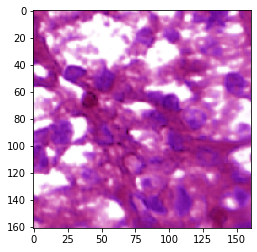

HT282N1_S1H3Fs4U1_AACGCGGTCTCCAGCC-1


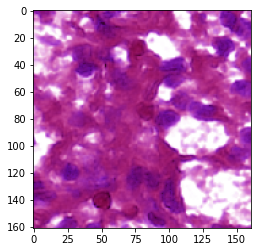

HT282N1_S1H3Fs4U1_AATCGGGACACTACGA-1


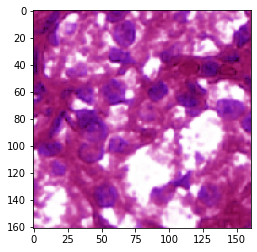

HT282N1_S1H3Fs4U1_ACATGGCGCCAAAGTA-1


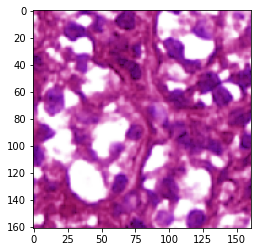

HT282N1_S1H3Fs4U1_ACGGCTGGATGTAGAA-1


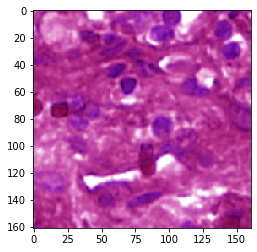

HT282N1_S1H3Fs4U1_AGACCCGCCCTCCTCG-1


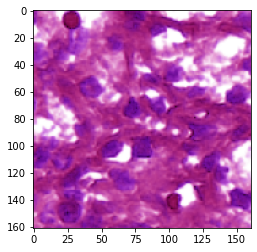

HT282N1_S1H3Fs4U1_AGGAAGCTGTCCGCCG-1


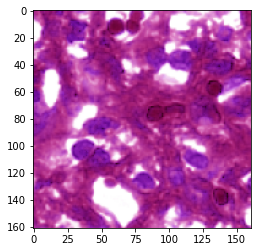

HT282N1_S1H3Fs4U1_AGTGACTGTGACACAA-1


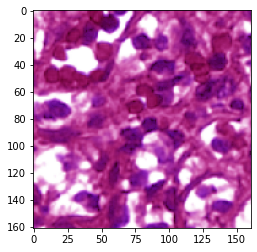

HT282N1_S1H3Fs4U1_ATATGGGATAGCAACT-1


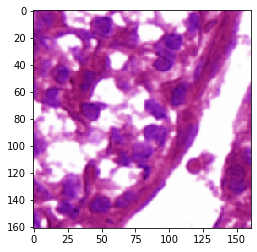

HT282N1_S1H3Fs4U1_ATGGGTGTATACCTCC-1


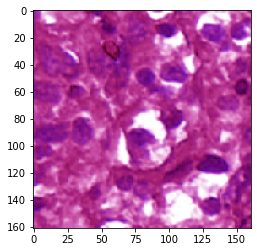

HT282N1_S1H3Fs4U1_CAACCAGTGGCCTACC-1


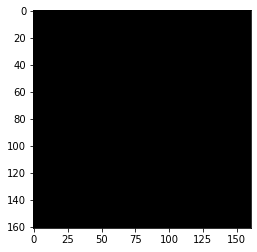

HT282N1_S1H3Fs4U1_CACTAAAGTTGCCTAT-1


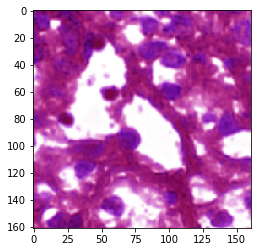

HT282N1_S1H3Fs4U1_CATCGCCCGCGGCCAA-1


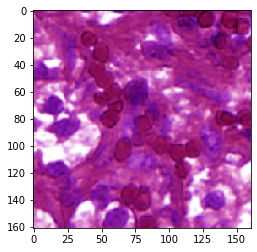

HT282N1_S1H3Fs4U1_CCATAGGTTGGCGTGG-1


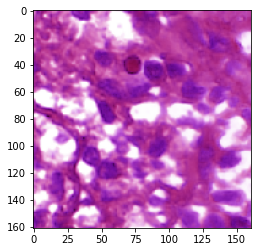

HT282N1_S1H3Fs4U1_CCGGAGCGTACTTTCT-1


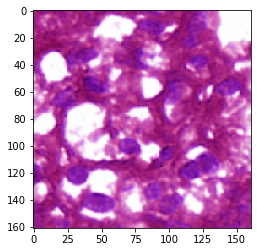

HT282N1_S1H3Fs4U1_CCTTTGAATTATGGCT-1


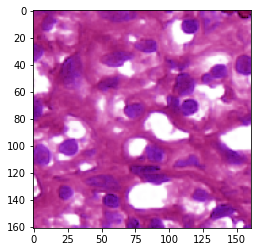

HT282N1_S1H3Fs4U1_CGCGGCTCAACTTGAA-1


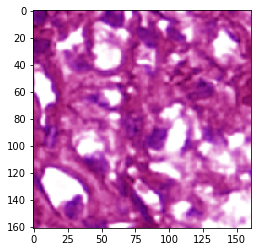

HT282N1_S1H3Fs4U1_CGTCAAGGCTATAAAT-1


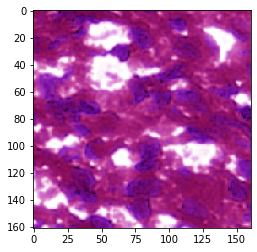

HT282N1_S1H3Fs4U1_CTATAAGAGCCAATCG-1


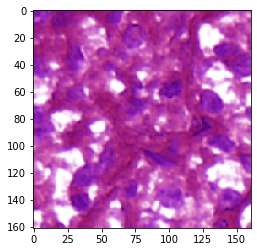

HT282N1_S1H3Fs4U1_CTGCGTTACGATATAA-1


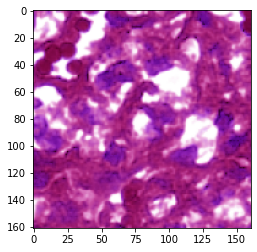

HT282N1_S1H3Fs4U1_GAAACCATGGTGCGCT-1


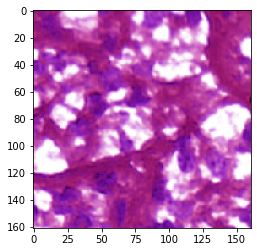

HT282N1_S1H3Fs4U1_GACGATATCACTGGGT-1


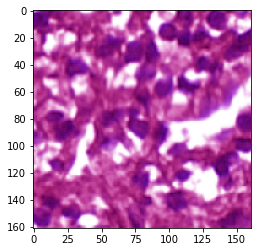

HT282N1_S1H3Fs4U1_GATATGCGGTAGCCAA-1


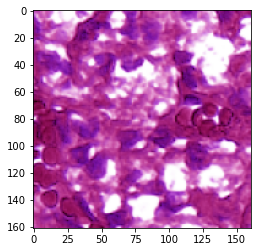

HT282N1_S1H3Fs4U1_GCATCGGCCGTGTAGG-1


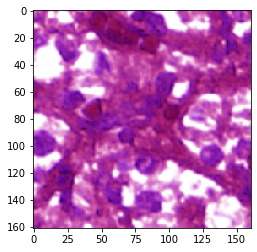

HT282N1_S1H3Fs4U1_GCGGTTCCCTATCATG-1


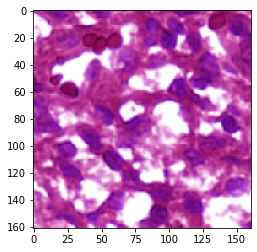

HT282N1_S1H3Fs4U1_GGAGAAGTCATTGGCA-1


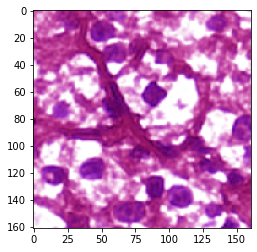

HT282N1_S1H3Fs4U1_GGGAGGATGCCCGAAA-1


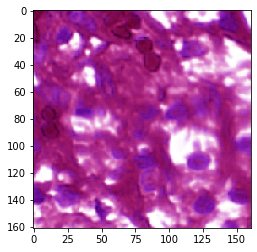

HT282N1_S1H3Fs4U1_GGTGGACTGCTCTGGC-1


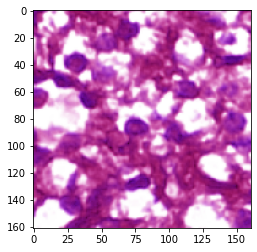

HT282N1_S1H3Fs4U1_GTCCGAGAGCAATCAT-1


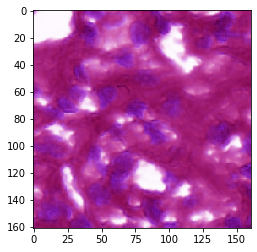

HT282N1_S1H3Fs4U1_GTGGTTACTTCTTTCG-1


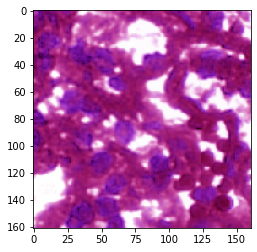

HT282N1_S1H3Fs4U1_TAACTCCATGGAGGCT-1


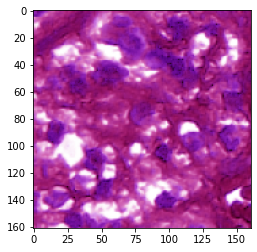

HT282N1_S1H3Fs4U1_TAGAATAGCCGATGAA-1


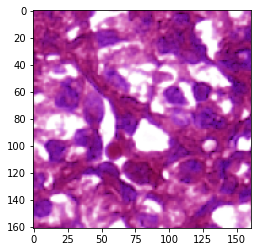

HT282N1_S1H3Fs4U1_TATGAAGAATTAAGGT-1


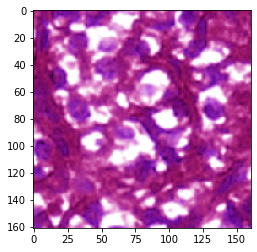

HT282N1_S1H3Fs4U1_TCCAACTTTAAATTCT-1


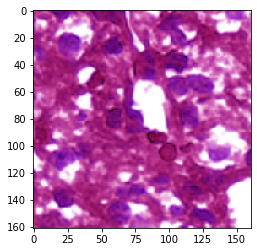

HT282N1_S1H3Fs4U1_TCGCGTAGCAGTGTCC-1


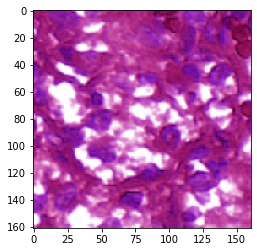

HT282N1_S1H3Fs4U1_TCTTACAGAGGTACCG-1


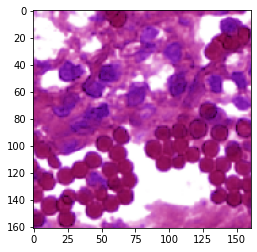

HT282N1_S1H3Fs4U1_TGCCCGATAGTTAGAA-1


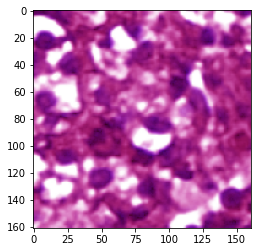

HT282N1_S1H3Fs4U1_TGGTGATCGTATTTGT-1


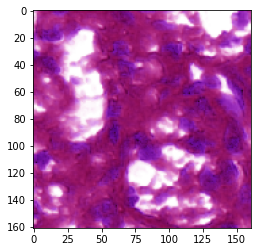

HT282N1_S1H3Fs4U1_TTAGACACGATCGTTG-1


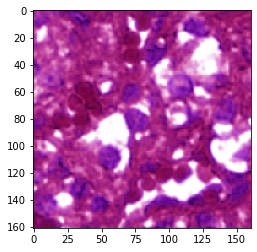

HT282N1_S1H3Fs4U1_TTCTTGAGCCGCGCTA-1


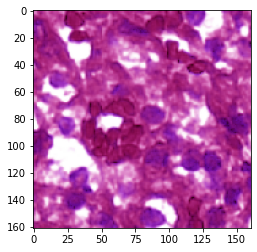

HT282N1_S1H3Fs4U1_TTGTTTCACATCCAGG-1


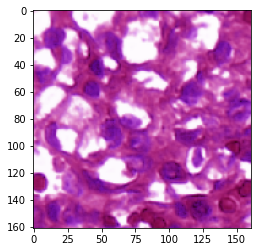

HT293N1_S1H3Fs1U1_AAGCTCTTTCATGGTG-1


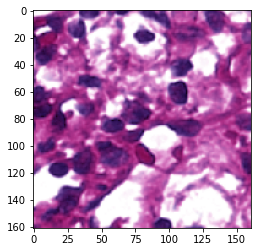

HT293N1_S1H3Fs1U1_ACCACAAGTTTCTATC-1


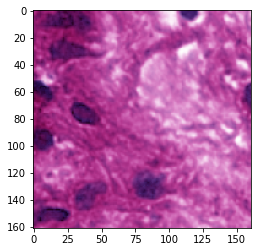

HT293N1_S1H3Fs1U1_ACTTATACTTACCCGG-1


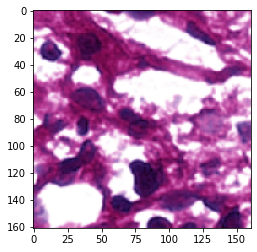

HT293N1_S1H3Fs1U1_AGGGAGACATACTTCG-1


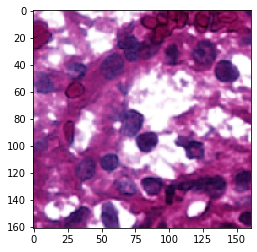

HT293N1_S1H3Fs1U1_ATAGGCTAGCTTCGCA-1


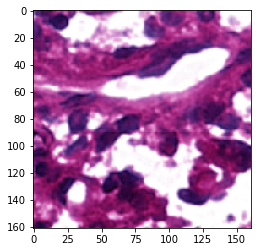

HT293N1_S1H3Fs1U1_ATTATTATGTCCGTCA-1


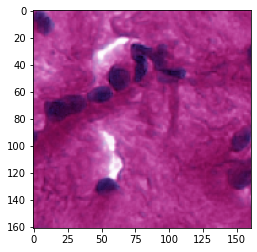

HT293N1_S1H3Fs1U1_CACCTTGCGAAACTCG-1


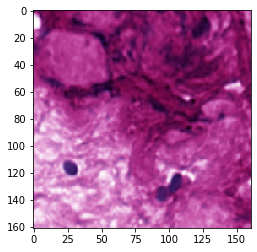

HT293N1_S1H3Fs1U1_CATTCGTCGTAGCGGT-1


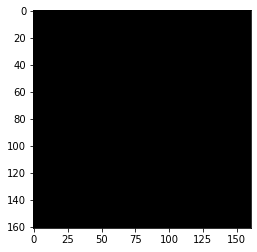

HT293N1_S1H3Fs1U1_CCTAAAGGCTGACGCT-1


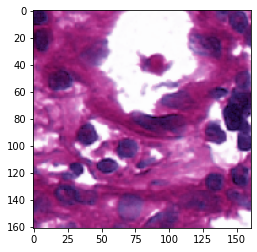

HT293N1_S1H3Fs1U1_CGCATGGTGCGATGCT-1


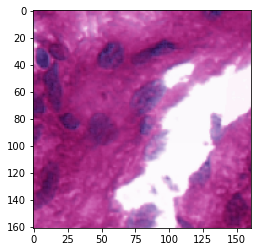

HT293N1_S1H3Fs1U1_CGTTGTTTCAATTCCC-1


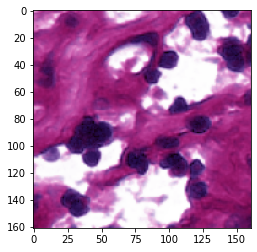

HT293N1_S1H3Fs1U1_CTGCTTGGCGATAGCT-1


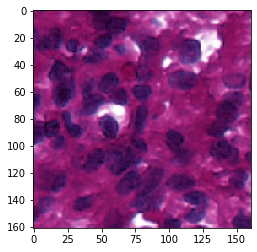

HT293N1_S1H3Fs1U1_GAATGCGAATCGGTTC-1


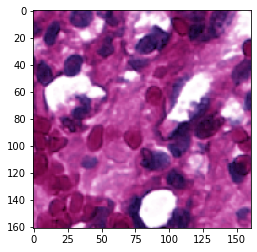

HT293N1_S1H3Fs1U1_GATCGCGGGCTCTCCA-1


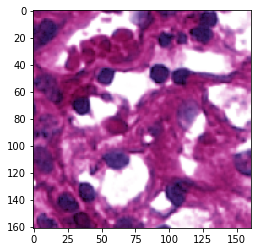

HT293N1_S1H3Fs1U1_GCGCTGCTTTGCATTT-1


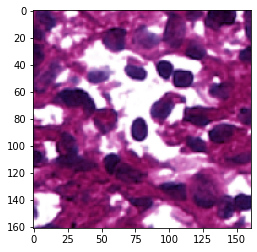

HT293N1_S1H3Fs1U1_GGATGTCCTTACCGCA-1


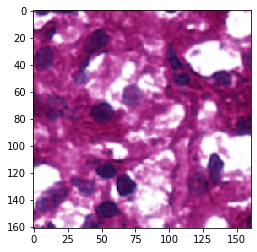

HT293N1_S1H3Fs1U1_GGTCTTGAGCGCTCTT-1


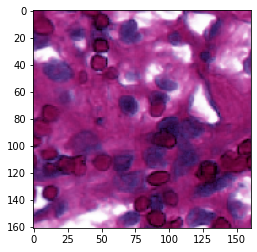

HT293N1_S1H3Fs1U1_GTGAAACGTGCTCCAC-1


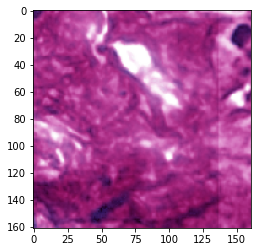

HT293N1_S1H3Fs1U1_TAACTATTACGCCAAA-1


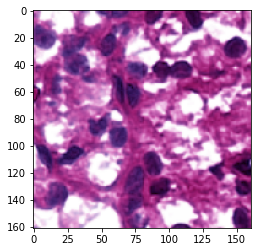

HT293N1_S1H3Fs1U1_TAGTTAAGATAGGATA-1


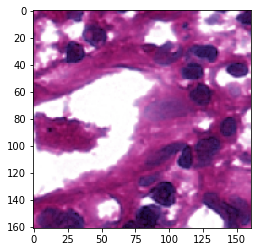

HT293N1_S1H3Fs1U1_TCCCGCGTACTCCTGG-1


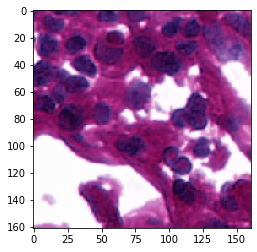

HT293N1_S1H3Fs1U1_TCTGAATTCCGTACAA-1


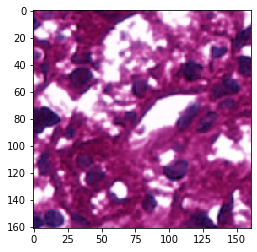

HT293N1_S1H3Fs1U1_TGCGGACTTGACTCCG-1


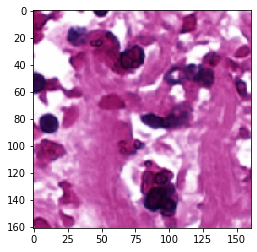

HT293N1_S1H3Fs1U1_TTAAGCGCCTGACCCA-1


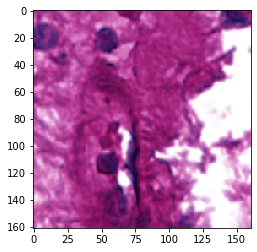

HT293N1_S1H3Fs1U1_TTGAGAAGTTTAGCAT-1


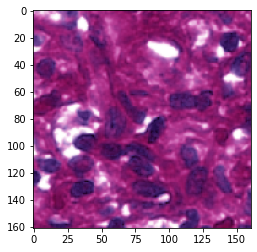

In [22]:
import matplotlib.pyplot as plt
for i, (img, imgid) in enumerate(zip(imgs, img_ids)):
    if i % 100 == 0:
        print(imgid)
        plt.imshow(img)
        plt.show()

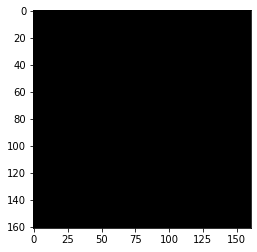

In [23]:
im = imgs[img_ids.index('HT282N1_S1H3Fs4U1_CAACCAGTGGCCTACC-1')]
plt.imshow(im)

In [25]:
import numpy as np
np.count_nonzero(np.sum(im, axis=-1)==0)

25921

In [26]:
# exclude the edge black images for now until you can fix it
import numpy as np
xs, ys = zip(*[(x, y) for x, y in zip(imgs, img_ids)
              if np.count_nonzero(np.sum(x, axis=-1)==0) > 10])
len(xs)

203

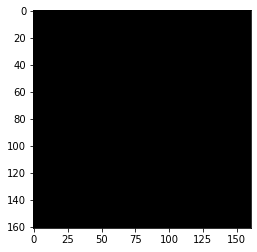

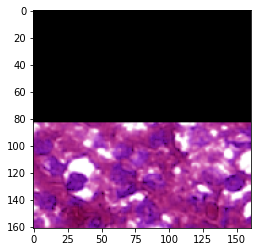

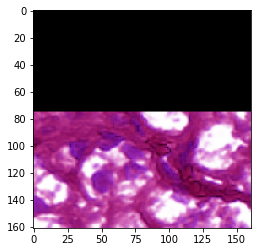

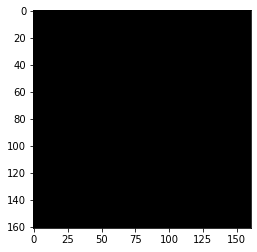

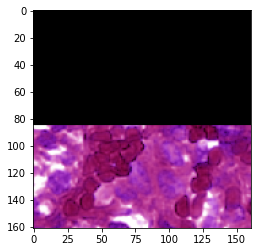

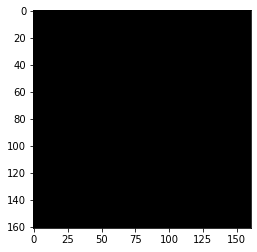

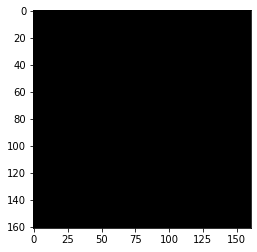

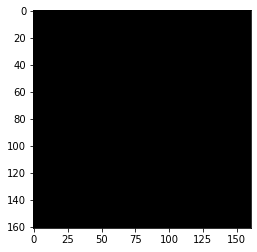

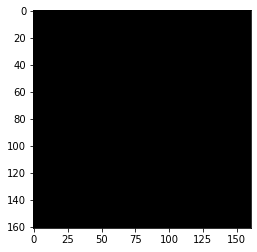

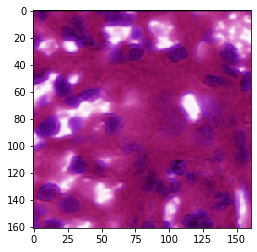

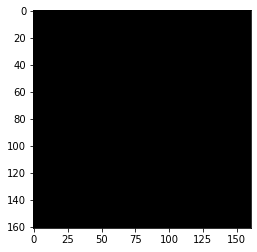

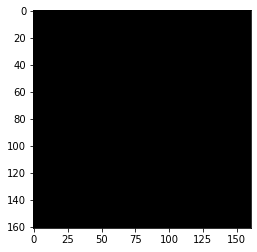

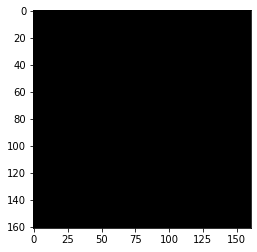

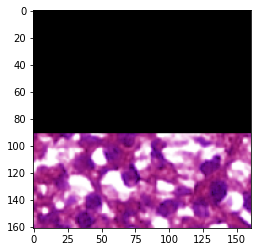

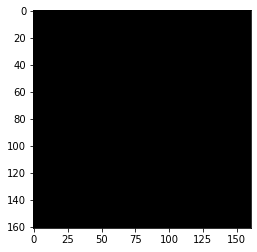

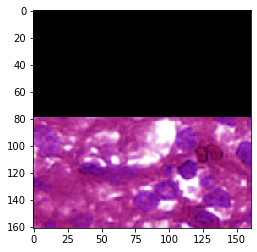

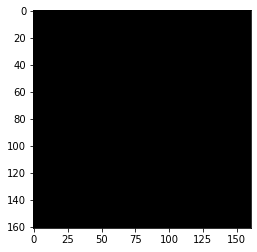

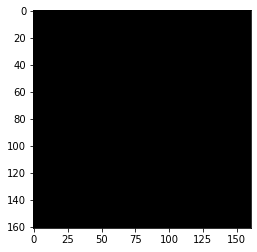

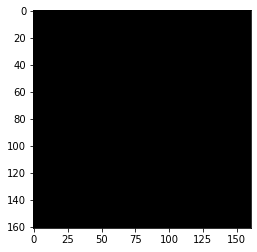

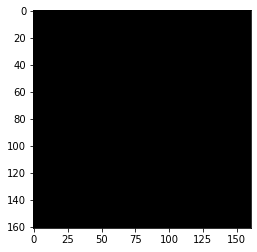

KeyboardInterrupt: 

In [27]:
for img in xs:
    plt.imshow(img)
    plt.show()

In [28]:
# exclude the edge black images for now until you can fix it
imgs, img_ids = zip(*[(x, y) for x, y in zip(imgs, img_ids)
              if np.count_nonzero(np.sum(x, axis=-1)==0) < 10])
len(imgs)

6349

In [29]:
output_dir = '/data/violet/st/ccrcc_ffpe_normalized'
samples = sorted(data_map.keys())
val_samples = []
for sample in samples:
    if sample not in val_samples:
        Path(os.path.join(output_dir, 'train', sample)).mkdir(parents=True, exist_ok=True)
    else:
        Path(os.path.join(output_dir, 'val', sample)).mkdir(parents=True, exist_ok=True)

In [30]:
for img, img_id in zip(imgs, img_ids):
    sample = '_'.join(img_id.split('_')[:-1])
    im = Image.fromarray(img)
    
    if sample in val_samples:
        im.save(os.path.join(output_dir, 'val', sample, f'{img_id}.jpeg'))
    else:
        im.save(os.path.join(output_dir, 'train', sample, f'{img_id}.jpeg'))

###### spot check location of image

In [16]:
import matplotlib.pyplot as plt

In [48]:
img_ids.index('HT264P1_S1H2Fs1_U1_CAAGAAACCCTAAACT-1')

778

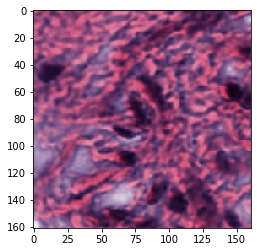

In [50]:
s = 778
plt.imshow(imgs[s])

In [51]:
img_ids[s]

'HT264P1_S1H2Fs1_U1_CAAGAAACCCTAAACT-1'

In [52]:
# [(i, x) for i, x in enumerate(img_ids) if 'RCC' in x][:5]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'highlight' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


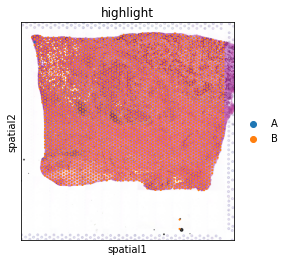

In [53]:
s_id = '_'.join(img_ids[s].split('_')[:-1])
a = sc.read_visium(filemap.set_index('sample_id').loc[s_id, 'spaceranger_output'])
a.obs.index = [f'{s_id}_{i}' for i in a.obs.index]
a.obs['highlight'] = ['A' if i==img_ids[s] else 'B'
                     for i in a.obs.index]
sc.pl.spatial(a, color='highlight')

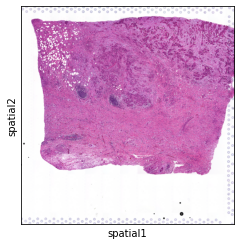

In [54]:
sc.pl.spatial(a)

In [31]:
a = sc.read_visium(filemap.set_index('sample_id').loc['NMK_20201012', 'spaceranger_output'])
a.uns['spatial'][list(a.uns['spatial'].keys())[0]]['scalefactors']['spot_diameter_fullres']

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


181.48018639605988

In [ ]:
sc.pl.spatial(a)

In [29]:
list(a.uns['spatial'].keys())[0]

'Colorectal_112C1_1'

In [30]:
a.uns['spatial'][list(a.uns['spatial'].keys())[0]]

{'images': {'hires': array([[[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
  
         [[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
  
         [[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
  
         ...,
  
         [[0.69803923, 0.69803923, 0.698039